<a href="https://colab.research.google.com/github/RW4CS/attention-networks-for-classification/blob/master/HAN_prequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://www.xlir.com/train_w_rel.pkl
!wget http://www.xlir.com/valid_w_rel.pkl
!wget http://www.xlir.com/test_w_rel.pkl

--2021-06-15 23:34:35--  http://www.xlir.com/train_w_rel.pkl
Resolving www.xlir.com (www.xlir.com)... 136.243.106.20
Connecting to www.xlir.com (www.xlir.com)|136.243.106.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145126511 (138M) [application/octet-stream]
Saving to: ‘train_w_rel.pkl’

train_w_rel.pkl     100%[===================>] 138.40M   107MB/s    in 1.3s    

2021-06-15 23:34:36 (107 MB/s) - ‘train_w_rel.pkl’ saved [145126511/145126511]

--2021-06-15 23:34:36--  http://www.xlir.com/valid_w_rel.pkl
Resolving www.xlir.com (www.xlir.com)... 136.243.106.20
Connecting to www.xlir.com (www.xlir.com)|136.243.106.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18493423 (18M) [application/octet-stream]
Saving to: ‘valid_w_rel.pkl’

valid_w_rel.pkl     100%[===================>]  17.64M  78.3MB/s    in 0.2s    

2021-06-15 23:34:36 (78.3 MB/s) - ‘valid_w_rel.pkl’ saved [18493423/18493423]

--2021-06-15 23:34:36--  http://www.xli

# 新段落

In [10]:
import os
import re

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import json
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from keras.engine.topology import Layer
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Embedding, GRU, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
import seaborn as sns

import sys
import nltk
from nltk import tokenize
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')

maxlen = 20
max_sentences = 50
max_words = 1000000
embedding_dim = 100
reviews = []
labels = []
texts = []
valid_reviews = []
valid_labels = []
valid_texts = []
test_reviews = []
test_labels = []
test_texts = []
glove_dir = "./glove.6B"
embeddings_index = {}

input_evd = pd.read_pickle('train_w_rel.pkl')
val_evd = pd.read_pickle('valid_w_rel.pkl')
test_evd = pd.read_pickle('test_w_rel.pkl')

input_evd = input_evd.sort_values(['date'])
val_evd = val_evd.sort_values(['date'])
test_evd = test_evd.sort_values(['date'])

#input_evd = pd.read_json('train.json')
#val_evd = pd.read_json('valid.json')
#test_evd = pd.read_json('test.json')

total_evd = pd.concat([input_evd, val_evd, test_evd])
total_evd = total_evd.sort_values(['date'])
print(total_evd)

ImportError: ignored

In [ ]:
# ### Counting dates script
# from dateutil.relativedelta import relativedelta
# import datetime
# from dateutil import parser

# timespan = relativedelta(months=6)

# starttime = datetime.date(1990, 1, 1)
# endtime = datetime.date(2021, 7, 30)

# cur1 = starttime
# cur2 = starttime + timespan


# windowcount = []
# while cur2 < endtime:
#     count = 0
#     for i in range(len(total_evd)):
#         temp_date = total_evd.iloc[i]['date'][:10]
#         temp_date = datetime.date(int(temp_date[:4]), int(temp_date[5:7]), int(temp_date[8:]))
#         if temp_date > cur1 and temp_date < cur2:
#             count += 1
#     print(count)
#     print(cur1)
#     print(cur2)
#     windowcount.append(count)
#     cur1 = cur1 + timespan
#     cur2 = cur2 + timespan

# print(windowcount)

# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# from dateutil.relativedelta import relativedelta
# import datetime
# from dateutil import parser

# years = ['10.1 - 10.7', '10.7 - 11.1', '11.1 - 11.7', '11.7 - 12.1', '12.1 - 12.7',
#          '12.7 - 13.1', '13.1 - 13.7', '13.7 - 14.1', '14.1 - 14.7', '14.7 - 15.1',
#          '15.1 - 15.7', '15.7 - 16.1', '16.1 - 16.7', '16.7 - 17.1', '17.1 - 17.7',
#          '17.7 - 18.1', '18.1 - 18.7', '18.7 - 19.1', '19.1 - 19.7', '19.7 - 20.1',
#          '20.1 - 20.7', '20.7 - 21.1', '21.1 - 21.7']
 
# obsnum = [408, 638, 725, 689, 816, 773, 624, 585, 718, 717, 693, 831, 3617, 1841, 1442, 1352, 1687, 1755, 2200, 2064, 3041, 3525, 1886]

# figure(figsize=(24, 10), dpi=80)
# plt.plot(years,obsnum)
# plt.title('6 month window count')
# plt.xlabel('period')
# plt.ylabel('count')
# plt.grid(True)
# plt.show()

In [8]:
# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name="W")
        self.b = K.variable(self.init((self.attention_dim,)), name="b")
        self.u = K.variable(self.init((self.attention_dim, 1)), name="u")
        self.train_wei = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

    def get_config(self):
        config = super(HierarchicalAttentionNetwork, self).get_config()
        config.update({"supports_masking" : self.supports_masking,
                       "attention_dim" : self.attention_dim,
                       })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def remove_html(str_a):
    p = re.compile(r'<.*?>')
    return p.sub('', str_a)


# replace all non-ASCII (\x00-\x7F) characters with a space
def replace_non_ascii(str_a):
    return re.sub(r'[^\x00-\x7f]', r'', str_a)

In [5]:
# for idx in range(input_evd.shape[0]):
#     claim = input_evd['text'][idx].strip()
#     evidence = input_evd['evidence'][idx].strip()
#     text = claim + ' ' + evidence
#     text = text.replace(u'\xa0', u' ')
#     texts.append(text)
#     sentences = tokenize.sent_tokenize(text)
#     reviews.append(sentences)
#     labels.append(input_evd['rating'][idx])


# tokenizer = Tokenizer(num_words=max_words, filters='!"“”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#     lower=True, split=' ', char_level=False, oov_token=None)
# tokenizer.fit_on_texts(texts)



# for idx in range(val_evd.shape[0]):
#     claim = val_evd['text'][idx].strip()
#     evidence = val_evd['evidence'][idx].strip()
#     text = claim + ' ' + evidence
#     text = text.replace(u'\xa0', u' ')
#     valid_texts.append(text)
#     sentences = tokenize.sent_tokenize(text)
#     valid_reviews.append(sentences)
#     valid_labels.append(val_evd['rating'][idx])

# tokenizer.fit_on_texts(valid_texts)


# for idx in range(test_evd.shape[0]):
#     claim = test_evd['text'][idx].strip()
#     evidence = test_evd['evidence'][idx].strip()
#     text = claim + ' ' + evidence
#     text = text.replace(u'\xa0', u' ')
#     test_texts.append(text)
#     sentences = tokenize.sent_tokenize(text)
#     test_reviews.append(sentences)
#     test_labels.append(test_evd['rating'][idx])

# tokenizer.fit_on_texts(test_texts)

# print(len(reviews))
# print(len(valid_reviews))
# print(len(test_reviews))

import datetime

total_reviews = []
total_texts = []
total_labels = []
total_dates = []

for idx in range(total_evd.shape[0]):
    claim = total_evd.iloc[idx]['text'].strip()
    evidence = total_evd.iloc[idx]['evidence'].strip()
    text = claim + ' ' + evidence
    text = text.replace(u'\xa0', u' ')
    total_texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    total_reviews.append(sentences)
    total_labels.append(total_evd.iloc[idx]['rating'])
    temp_date = total_evd.iloc[idx]['date'][:10]
    total_dates.append(datetime.date(int(temp_date[:4]), int(temp_date[5:7]), int(temp_date[8:])))

tokenizer = Tokenizer(num_words=max_words, filters='!"“”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(total_texts)

print(len(total_reviews))

33697


In [6]:
# data = np.zeros((len(texts), max_sentences, maxlen), dtype='int32')

# for i, sentences in enumerate(reviews):
#     for j, sent in enumerate(sentences):
#         if j < max_sentences:
#             sent = sent.replace(u'\xa0', u' ')
#             wordTokens = text_to_word_sequence(sent,
#                                                filters = '!"“”#$%&()*+,-./\:;<=>?@[\\]^_`{|}~\t\n',
#                                                lower = True,
#                                                split = " ")
#             #wordTokens = text_to_word_sequence(sent)
#             #tokenizer.fit_on_sequences(wordTokens)
#             #tokenizer.fit_on_texts(sent)
#             k = 0
#             for _, word in enumerate(wordTokens):
#                 if word == 'healthpocket' or (i == 2217 and k == 0):
#                     k = k+1 
#                 elif k < maxlen and tokenizer.word_index[word] < max_words:
#                     data[i, j, k] = tokenizer.word_index[word]
#                     k = k + 1


# vl_data = np.zeros((len(valid_texts), max_sentences, maxlen), dtype='int32')

# for i, sentences in enumerate(valid_reviews):
#     for j, sent in enumerate(sentences):
#         if j < max_sentences:
#             sent = sent.replace(u'\xa0', u' ')
#             wordTokens = text_to_word_sequence(sent,
#                                                filters = '!"“”#$%&()*+,-./\:;<=>?@[\\]^_`{|}~\t\n',
#                                                lower = True,
#                                                split = " ")
#             k = 0
#             for _, word in enumerate(wordTokens):
#                 if k < maxlen and tokenizer.word_index[word] < max_words:
#                     vl_data[i, j, k] = tokenizer.word_index[word]
#                     k = k + 1


# ts_data = np.zeros((len(test_texts), max_sentences, maxlen), dtype='int32')

# for i, sentences in enumerate(test_reviews):
#     for j, sent in enumerate(sentences):
#         if j < max_sentences:
#             sent = sent.replace(u'\xa0', u' ')
#             wordTokens = text_to_word_sequence(sent,
#                                                filters = '!"“”#$%&()*+,-./\:;<=>?@[\\]^_`{|}~\t\n',
#                                                lower = True,
#                                                split = " ")
#             k = 0
#             for _, word in enumerate(wordTokens):
#                 if k < maxlen and tokenizer.word_index[word] < max_words:
#                     ts_data[i, j, k] = tokenizer.word_index[word]
#                     k = k + 1


total_data = np.zeros((len(total_texts), max_sentences, maxlen), dtype='int32')

for i, sentences in enumerate(total_reviews):
    for j, sent in enumerate(sentences):
        if j < max_sentences:
            sent = sent.replace(u'\xa0', u' ')
            wordTokens = text_to_word_sequence(sent,
                                               filters = '!"“”#$%&()*+,-./\:;<=>?@[\\]^_`{|}~\t\n',
                                               lower = True,
                                               split = " ")
            k = 0
            for _, word in enumerate(wordTokens):
                if word == 'healthpocket':
                     k = k+1
                elif k < maxlen and tokenizer.word_index[word] < max_words:
                    total_data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1


word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 301920 unique tokens.


In [10]:
# labels = to_categorical(np.asarray(labels))
# print('Shape of reviews (data) tensor:', data.shape)
# print('Shape of sentiment (label) tensor:', labels.shape)


# valid_labels = to_categorical(np.asarray(valid_labels))
# print('Shape of reviews (data) tensor:', data.shape)
# print('Shape of sentiment (label) tensor:', valid_labels.shape)


# test_labels = to_categorical(np.asarray(test_labels))
# print('Shape of test reviews (data) tensor:', ts_data.shape)
# print('Shape of test sentiment (label) tensor:', test_labels.shape)

total_labels = to_categorical(np.asarray(total_labels))
print('Shape of test reviews (data) tensor:', total_data.shape)
print('Shape of test sentiment (label) tensor:', total_labels.shape)

Shape of test reviews (data) tensor: (33697, 50, 20)
Shape of test sentiment (label) tensor: (33697, 3)


In [ ]:
# ### not used for prequential

# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]

# x_train = data
# y_train = labels

# vl_indices = np.arange(vl_data.shape[0])
# np.random.shuffle(vl_indices)
# vl_data = vl_data[vl_indices]
# valid_labels = valid_labels[vl_indices]

# x_val = vl_data
# y_val = valid_labels

# ts_indices = np.arange(ts_data.shape[0])
# np.random.shuffle(ts_indices)
# ts_data = ts_data[ts_indices]
# test_labels = test_labels[ts_indices]

# x_test = ts_data
# y_test = test_labels

# print('Number of positive and negative reviews in training and validation set')
# print(y_train.sum(axis=0))
# print(y_val.sum(axis=0))
# print(y_test.sum(axis=0))

In [11]:
from dateutil.relativedelta import relativedelta
import datetime

timespan = relativedelta(months=6)
starttime = datetime.date(2010, 1, 1)
endtime = datetime.date(2021, 7, 30)

trainsetsX = []
trainsetsY = []
testsetsX = []
testsetsY = []

first_train_index = 0
for i in range(total_data.shape[0]):
    if total_dates[i] < starttime:
        continue
    else:
      first_train_index = i
      break
first_train_X = total_data[:first_train_index+1]
first_train_Y = total_labels[:first_train_index+1]
print(first_train_X.shape)

trainsetsX.append(first_train_X)
trainsetsY.append(first_train_Y)

first_test_time = starttime + timespan

first_test_index = 0
for i in range(total_data.shape[0]):
    if total_dates[i] < first_test_time:
        continue
    else:
      first_test_index = i
      break
first_test_X = total_data[first_train_index+1:first_test_index+1]
first_test_Y = total_labels[first_train_index+1:first_test_index+1]
print(first_test_X.shape)

testsetsX.append(first_test_X)
testsetsY.append(first_test_Y)

cur1 = first_test_time
cur2 = cur1 + timespan
while cur2 < endtime:
    trainind = 0
    testind = 0
    for i in range(total_data.shape[0]):
        if total_dates[i] < cur1:
            continue
        else:
            trainind = i
            break
    for j in range(trainind, total_data.shape[0]):
        if total_dates[j] < cur2:
            continue
        else:
            testind = j
            break
    trX = total_data[:trainind+1]
    trY = total_labels[:trainind+1]
    tstX = total_data[trainind+1:testind+1]
    tstY = total_labels[trainind+1:testind+1]
    trainsetsX.append(trX)
    trainsetsY.append(trY)
    testsetsX.append(tstX)
    testsetsY.append(tstY)
    cur1 = cur1 + timespan
    cur2 = cur2 + timespan

print(len(trainsetsX))
print(trainsetsX[0].shape)

(931, 50, 20)
(408, 50, 20)
23
(931, 50, 20)


In [32]:
f = open('glove.6B.100d.txt','r+', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [12]:
tf.executing_eagerly()

True

In [13]:
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=True)

sentence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
#lstm_word = Bidirectional(LSTM(100, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)
Model.compile
review_input = Input(shape=(max_sentences, maxlen), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
#lstm_sentence = Bidirectional(LSTM(100, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(3, activation='softmax')(attn_sentence)

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2), but
are not present in its tracked objects:
  <tf.Variable 'hierarchical_attention_network_2/b:0' shape=(100,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


NotImplementedError: ignored

In [31]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, tf.float32), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), tf.float32), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, tf.float32), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), tf.float32), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, tf.float32), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), tf.float32), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, tf.float32), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), tf.float32), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def dfdtp(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, tf.float32), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), tf.float32), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, tf.float32), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), tf.float32), axis=0)
    return 0.5 * (fp + fn) / ((tp + 0.5 * (fp + fn)) ** 2 + K.epsilon())

def dfdfp(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, tf.float32), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), tf.float32), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, tf.float32), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), tf.float32), axis=0)
    return -0.5 * tp / ((tp + 0.5 * (fp + fn)) ** 2 + K.epsilon())

def dfdfn(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, tf.float32), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), tf.float32), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, tf.float32), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), tf.float32), axis=0)
    return -0.5 * tp / ((tp + 0.5 * (fp + fn)) ** 2 + K.epsilon())

In [ ]:
# #!pip install --upgrade keras==2.2.4
# from keras.legacy import interfaces
# from keras.optimizers import Optimizer


# class AdamAccumulate(Optimizer):

#     def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
#                  epsilon=None, decay=0., amsgrad=False, accum_iters=1, **kwargs):
#         if accum_iters < 1:
#             raise ValueError('accum_iters must be >= 1')
#         super(AdamAccumulate, self).__init__(name = 'AdamAccumulate', **kwargs)
#         with K.name_scope(self.__class__.__name__):
#             self.iterations = K.variable(0, dtype='int64', name='iterations')
#             self.lr = K.variable(lr, name='lr')
#             self.beta_1 = K.variable(beta_1, name='beta_1')
#             self.beta_2 = K.variable(beta_2, name='beta_2')
#             self.decay = K.variable(decay, name='decay')
#         if epsilon is None:
#             epsilon = K.epsilon()
#         self.epsilon = epsilon
#         self.initial_decay = decay
#         self.amsgrad = amsgrad
#         self.accum_iters = K.variable(accum_iters, K.dtype(self.iterations))
#         self.accum_iters_float = K.cast(self.accum_iters, K.floatx())

#     @interfaces.legacy_get_updates_support
#     def get_updates(self, loss, params):
#         grads = self.get_gradients(loss, params)
#         self.updates = [K.update_add(self.iterations, 1)]

#         lr = self.lr

#         completed_updates = K.cast(K.tf.floordiv(self.iterations, self.accum_iters), K.floatx())

#         if self.initial_decay > 0:
#             lr = lr * (1. / (1. + self.decay * completed_updates))

#         t = completed_updates + 1

#         lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

#         # self.iterations incremented after processing a batch
#         # batch:              1 2 3 4 5 6 7 8 9
#         # self.iterations:    0 1 2 3 4 5 6 7 8
#         # update_switch = 1:        x       x    (if accum_iters=4)  
#         update_switch = K.equal((self.iterations + 1) % self.accum_iters, 0)
#         update_switch = K.cast(update_switch, K.floatx())

#         ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
#         vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
#         gs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]

#         if self.amsgrad:
#             vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
#         else:
#             vhats = [K.zeros(1) for _ in params]

#         self.weights = [self.iterations] + ms + vs + vhats

#         for p, g, m, v, vhat, tg in zip(params, grads, ms, vs, vhats, gs):

#             sum_grad = tg + g
#             avg_grad = sum_grad / self.accum_iters_float

#             m_t = (self.beta_1 * m) + (1. - self.beta_1) * avg_grad
#             v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(avg_grad)

#             if self.amsgrad:
#                 vhat_t = K.maximum(vhat, v_t)
#                 p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
#                 self.updates.append(K.update(vhat, (1 - update_switch) * vhat + update_switch * vhat_t))
#             else:
#                 p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

#             self.updates.append(K.update(m, (1 - update_switch) * m + update_switch * m_t))
#             self.updates.append(K.update(v, (1 - update_switch) * v + update_switch * v_t))
#             self.updates.append(K.update(tg, (1 - update_switch) * sum_grad))
#             new_p = p_t

#             # Apply constraints.
#             if getattr(p, 'constraint', None) is not None:
#                 new_p = p.constraint(new_p)

#             self.updates.append(K.update(p, (1 - update_switch) * p + update_switch * new_p))
#         return self.updates

#     def get_config(self):
#         config = {'lr': float(K.get_value(self.lr)),
#                   'beta_1': float(K.get_value(self.beta_1)),
#                   'beta_2': float(K.get_value(self.beta_2)),
#                   'decay': float(K.get_value(self.decay)),
#                   'epsilon': self.epsilon,
#                   'amsgrad': self.amsgrad}
#         base_config = super(AdamAccumulate, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# from tensorflow.keras.optimizers import Adam
# import time

# epochs = 30
# batch_s = 64
# learning_rate = 1e-3

# opt = Adam(lr = learning_rate, decay = learning_rate/epochs)

# newopt = AdamAccumulate(lr=0.001, beta_1=0.9, beta_2=0.999,
#                  epsilon=None, decay=1e-5, amsgrad=False, accum_iters=5)

# model = Model(review_input, preds)


# def step2(y_true, y_pred):
#     # partial f1 / partial tp
#     with tf.GradientTape() as tape_1:
#         fun_1 = dfdtp(y_true, y_pred)
#         fun_2 = dfdfp(y_true, y_pred)
#         fun_3 = dfdfn(y_true, y_pred)
#     grads_1 = tape_1.gradient(fun_1, model.trainable_variables)
#     grads_2 = tape_1.gradient(fun_2, model.trainable_variables)
#     grads_3 = tape_1.gradient(fun_3, model.trainable_variables)
#     grad = dfdtp(y_true, y_pred) * grads_1
#     # partial f1 / partial fp
#     grad = grad + dfdfp(y_true, y_pred) * grads_2
#     # partial f1 / partial fn
#     grad = grad + dfdfn(y_true, y_pred) * grads_3

#     newopt.apply_gradients(zip(grad, model.trainable_variables))


# # Compute the number of batch updates in one epoch
# num_update = int(x_train.shape[0]/batch_s)

# # Start the main loop
# for epoch in range(epochs):
#     print("[INFO] starting epoch {}/{}...".format(epoch + 1, epochs), end="")
#     sys.stdout.flush()
#     epoch_start = time.time()
    
#     # Start the batch loop
#     for i in range(0, batch_s):
#         start = i * batch_s
#         end = start + batch_s
#         sub_x_train = x_train[start:end]
#         sub_y_train = y_train[start:end]
#         sub_y_pred = model.predict(sub_x_train, batch_size=batch_s, verbose=1)
#         # do step
#         step2(sub_y_train, sub_y_pred)

#     valid_score = model.evaluate(x_val, y_val, batch_size = batch_s * 8)
#     print("valid loss, valid acc:", valid_score)
#     epoch_finish = time.time()
#     elapsed = (epoch_start - epoch_finish) / 60.0
#     print("took {:.4} minutes".format(elapsed))


In [ ]:
# !pip install h5py
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model

# filepath = "LSTMce-{epoch:02d}-{val_f1:.2f}.hdf5"
# mc = ModelCheckpoint(filepath=filepath, save_best_only=False ,monitor='val_f1', mode='max', verbose=1)

# es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=10)

# newopt = AdamAccumulate(lr=0.001, beta_1=0.9, beta_2=0.999,
#                  epsilon=None, decay=1e-5, amsgrad=False, accum_iters=5)

# model = Model(review_input, preds)

# model.compile(loss=f1_loss, optimizer=newopt, 
#               metrics=['acc', f1])

# print("model fitting - Hierachical attention network")
# model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=1024, callbacks = [es, mc])


# print("Evaluate on test data")
# results = model.evaluate(x_test, y_test, batch_size=1024)
# print("test loss, test acc:", results)


In [35]:
train_val_ratio = 0.8

!pip install h5py
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import sklearn
from sklearn import metrics
from sklearn.metrics import f1_score

rst_list = []
rst_list_ce = []

#filepath = "LSTMce-{epoch:02d}-{val_f1:.2f}.hdf5"
#mc = ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_f1', mode='max', verbose=1)
#es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=8)

#newopt = AdamAccumulate(lr=0.001, beta_1=0.9, beta_2=0.999,
#                 epsilon=None, decay=1e-5, amsgrad=False, accum_iters=5)

for j in range(len(trainsetsX)):
    checkpoint_filepath = 'checkpoint.hdf5'
    mc = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_f1', mode='max', verbose=1)
    es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=10)

    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=True)
    sentence_input = Input(shape=(maxlen,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    #lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
    lstm_word = Bidirectional(LSTM(100, return_sequences=True))(embedded_sequences)
    attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
    sentenceEncoder = Model(sentence_input, attn_word)
    review_input = Input(shape=(max_sentences, maxlen), dtype='int32')
    review_encoder = TimeDistributed(sentenceEncoder)(review_input)
    #lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
    lstm_sentence = Bidirectional(LSTM(100, return_sequences=True))(review_encoder)
    attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
    preds = Dense(3, activation='softmax')(attn_sentence)

    model = Model(review_input, preds)
    model.compile(loss=f1_loss, optimizer='Adam', metrics=['acc', f1])
    print("model fitting - Hierachical attention network")
    print("This is the %s-th rolling window training process" % j)
    print("--------------------------------------------------------------\n")
    indices = np.arange(trainsetsX[j].shape[0])
    np.random.shuffle(indices)
    x_train = trainsetsX[j][indices][:int(train_val_ratio * len(indices))]
    y_train = np.array(trainsetsY[j])[indices][:int(train_val_ratio * len(indices))]
    x_val = trainsetsX[j][indices][int(train_val_ratio * len(indices)):]
    y_val = np.array(trainsetsY[j])[indices][int(train_val_ratio * len(indices)):]

    ts_indices = np.arange(testsetsX[j].shape[0])
    np.random.shuffle(ts_indices)
    x_test = np.array(testsetsX[j])[ts_indices]
    y_test = np.array(testsetsY[j])[ts_indices]
    print("%s-th window: Start training for model 1 with F1 direct loss" % (j))
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, callbacks = [es, mc])
    print("Loading best model for F1-loss ...")
    model.load_weights(checkpoint_filepath)

    print("Evaluate on test data based on best model")
    results = model.evaluate(x_test, y_test, batch_size=64)
    print(results)
    print("Calculate the macro F1-score")
    rst_list.append([results[1], results[2]])


for j in range(len(trainsetsX)):
    checkpoint_filepath = 'checkpoint.hdf5'
    mc = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_f1', mode='max', verbose=1)
    es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=10)

    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=True)
    sentence_input = Input(shape=(maxlen,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    #lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
    lstm_word = Bidirectional(LSTM(100, return_sequences=True))(embedded_sequences)
    attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
    sentenceEncoder = Model(sentence_input, attn_word)
    review_input = Input(shape=(max_sentences, maxlen), dtype='int32')
    review_encoder = TimeDistributed(sentenceEncoder)(review_input)
    #lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
    lstm_sentence = Bidirectional(LSTM(100, return_sequences=True))(review_encoder)
    attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
    preds = Dense(3, activation='softmax')(attn_sentence)

    model = Model(review_input, preds)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc', f1])
    print("model fitting - Hierachical attention network")
    print("This is the %s-th rolling window training process" % j)
    print("--------------------------------------------------------------\n")
    indices = np.arange(trainsetsX[j].shape[0])
    np.random.shuffle(indices)
    x_train = trainsetsX[j][indices][:int(train_val_ratio * len(indices))]
    y_train = np.array(trainsetsY[j])[indices][:int(train_val_ratio * len(indices))]
    x_val = trainsetsX[j][indices][int(train_val_ratio * len(indices)):]
    y_val = np.array(trainsetsY[j])[indices][int(train_val_ratio * len(indices)):]

    ts_indices = np.arange(testsetsX[j].shape[0])
    np.random.shuffle(ts_indices)
    x_test = np.array(testsetsX[j])[ts_indices]
    y_test = np.array(testsetsY[j])[ts_indices]
    print("%s-th window: Start training for model 2 with crossentropy loss" % (j))
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, callbacks = [es, mc])
    print("Loading best model for categorical crossentropy ...")
    model.load_weights(checkpoint_filepath)

    print("Evaluate on test data based on best model")
    results = model.evaluate(x_test, y_test, batch_size=64)
    print(results)
    print("Calculate the macro F1-score")
    rst_list_ce.append([results[1], results[2]])



AttributeError: ignored

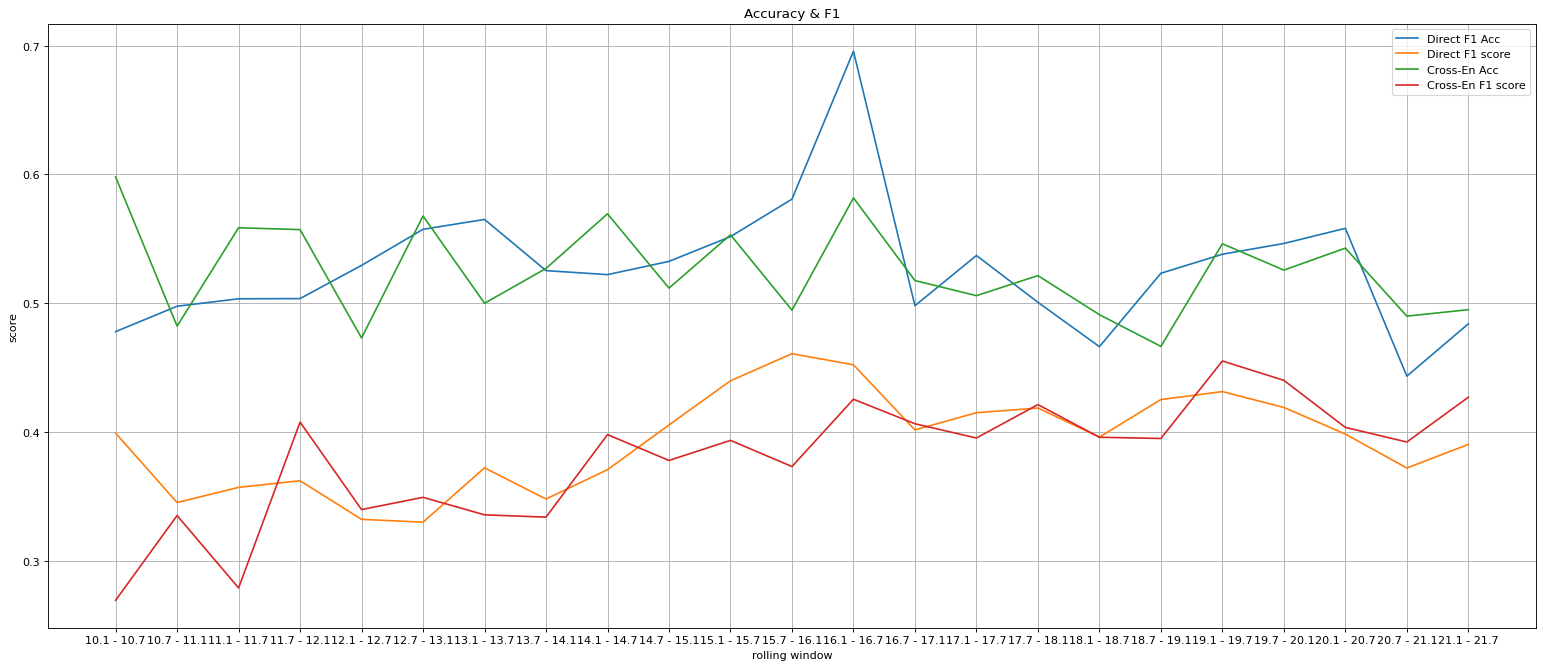

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

F1_acc_ = []
F1_f1_ = []
ce_acc_ = []
ce_f1_ = []

index_ls = []

for i in range(len(rst_list)):
    F1_acc_.append(rst_list[i][0])
    F1_f1_.append(rst_list[i][1])
    ce_acc_.append(rst_list_ce[i][0])
    ce_f1_.append(rst_list_ce[i][1])
    index_ls.append(i)


figure(figsize=(24, 10), dpi=80)
plt.plot(years, F1_acc_, label="Direct F1 Acc")
plt.plot(years, F1_f1_, label="Direct F1 score")
plt.plot(years, ce_acc_, label="Cross-En Acc")
plt.plot(years, ce_f1_, label="Cross-En F1 score")
plt.title('Accuracy & F1')
plt.xlabel('rolling window')
plt.ylabel('score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(test_acc_ls)
print(test_f1_ls)

[0.4166666567325592, 0.43894898891448975, 0.40689656138420105, 0.4616497755050659, 0.4950980246067047, 0.536774218082428, 0.4761904776096344, 0.5, 0.5, 0.6016597747802734, 0.5014367699623108, 0.5257484912872314, 0.6268656849861145, 0.5056910514831543, 0.517671525478363, 0.4741124212741852, 0.4893491268157959, 0.5034052133560181, 0.5353260636329651, 0.5339105129241943, 0.5408496856689453, 0.48771533370018005, 0.47299423813819885]
[0.32114359736442566, 0.30250558257102966, 0.3214755654335022, 0.3309433162212372, 0.33718961477279663, 0.33309701085090637, 0.35130441188812256, 0.3775554299354553, 0.3485349714756012, 0.42363178730010986, 0.41184529662132263, 0.39047738909721375, 0.4350147545337677, 0.39116379618644714, 0.38912758231163025, 0.3891584575176239, 0.4149392247200012, 0.4011063277721405, 0.43092647194862366, 0.39547449350357056, 0.38908419013023376, 0.38588258624076843, 0.4203190207481384]


In [ ]:
path2 = "LSTMce-13-0.51.hdf5"

best_model = Model(review_input, preds)
best_model.load_weights(path2)
best_model.compile(loss="categorical_crossentropy", optimizer='adam', 
              metrics=['acc', f1])

print("Evaluate on best model")
best_results = best_model.evaluate(x_test, y_test, batch_size=1024)
print("Best model test loss, test acc:", best_results)

Evaluate on best model
1/1 [==============================] - 3s 3s/step - loss: 1.3393 - acc: 0.4637 - f1: 0.3546
Best model test loss, test acc: [1.33932626247406, 0.4636785089969635, 0.35462138056755066]


In [ ]:
from sklearn.metrics import classification_report

thresh = 0.5
best_y_pred = best_model.predict(x_test, batch_size=1024, verbose=1)
best_y_pred_bool = np.argmax(best_y_pred, axis=1)

best_y_p2 = np.array([[1 if i > thresh else 0 for i in j] for j in best_y_pred])
print(classification_report(y_test, best_y_p2))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

           0       0.30      0.31      0.30       144
           1       0.64      0.51      0.57       397
           2       0.27      0.15      0.19       106

   micro avg       0.50      0.41      0.45       647
   macro avg       0.40      0.32      0.35       647
weighted avg       0.50      0.41      0.45       647
 samples avg       0.41      0.41      0.41       647



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
